In [2]:
# seetup
import tensorflow as tf

2025-03-11 16:12:10.758193: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-11 16:12:10.758526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-11 16:12:10.925901: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 16:12:11.260254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-11 16:12:13.454629: W tensorflow/compiler/tf2

For example, consider the function y = x * x. The gradient at x = 3.0 can be computed as:

In [21]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = x * x
dy_dx = g.gradient(y, x)
print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


 nested gradient

derivadas de orden superior



In [22]:
x = tf.constant(5.0)
with tf.GradientTape() as g:
  g.watch(x)
  with tf.GradientTape() as gg:
    gg.watch(x)
    y = x * x
  dy_dx = gg.gradient(y, x)  # dy_dx = 2 * x
d2y_dx2 = g.gradient(dy_dx, x)  # d2y_dx2 = 2
print(dy_dx)

print(d2y_dx2)

tf.Tensor(10.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


By default, the resources held by a GradientTape are released as soon as GradientTape.gradient() method is called. To compute multiple gradients over the same computation, create a persistent gradient tape. This allows multiple calls to the gradient() method as resources are released when the tape object is garbage collected.


let's see what happens if we do not use persis=true:



In [35]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = x * x
  z = y * y

dz_dx = g.gradient(z, x)  # (4*x^3 at x = 3)
print(dz_dx)

dy_dx = g.gradient(y, x)
print(dy_dx)

tf.Tensor(108.0, shape=(), dtype=float32)


RuntimeError: A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)

The error means you're trying to compute gradients twice using the same GradientTape without setting persistent=True.

Why?
By default, tf.GradientTape is not persistent, meaning it automatically deletes its internal data after calling .gradient() once.
If you need multiple gradient calculations, add persistent=True when creating th

In [34]:
x = tf.constant(3.0)
with tf.GradientTape(persistent=True) as g:
  g.watch(x)
  y = x * x
  z = y * y
dz_dx = g.gradient(z, x)  # (4*x^3 at x = 3)
print(dz_dx)


# now that is persistent we can reuse it
dy_dx = g.gradient(y, x)
print(dy_dx)

tf.Tensor(108.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


In [36]:
# drop referebce
del g

Gradient tape for differentiation


Let's explore how you can use [tf.GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape) to do automatic differentiation.

Gradient Calculation: The goal is to compute the gradient of a scalar value (z = y^2) with respect to a tensor x.
TensorFlow's GradientTape requires a scalar output to compute gradients. Since y = tf.reduce_sum(x) produces a scalar, this step ensures the function meets that requirement.

Since:

- \( y = \text{tf.reduce_sum}(x) \)  
- \( z = y^2 \)  


$$
z = y^2
$$



By the chain rule:

$$
\frac{\partial z}{\partial x_{ij}} = \frac{\partial z}{\partial y} \cdot \frac{\partial y}{\partial x_{ij}}
$$

Where:

- \( \frac{\partial z}{\partial y} = 2y \)  
- \( \frac{\partial y}{\partial x_{ij}} = 1 \)  since y is the sum of elements in x

So,

$$
\frac{\partial z}{\partial x_{ij}} = 2y
$$

Since \( y = \text{tf.reduce_sum}(x) = 4 \), each element in \( dz\_dx \) will be 8.


note that in the following example x is not a scalar, so we're gonna have to use reduce_sum to compute the gradient.

In [33]:
# Define a 2x2 array of 1's
x = tf.ones((2,2))

print(x, '\n')

with tf.GradientTape() as t:
    # Record the actions performed on tensor x with `watch`
    t.watch(x) 

    # Define y as the sum of the elements in x
    y =  tf.reduce_sum(x)
    
    #
    
    print(y, '\n') # suma de los elementos de la matriz
        # 4 pues suma todos los elementos de la matriz, que son 4 y son 1s

    # Let z be the square of y
    z = tf.square(y) # es y al cuadrado, 4**2
    
    # 
    print(z, '\n')

# Get the derivative of z wrt the original input tensor x
dz_dx = t.gradient(z, x)

# Print our result
print(dz_dx)

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32) 

tf.Tensor(4.0, shape=(), dtype=float32) 

tf.Tensor(16.0, shape=(), dtype=float32) 

tf.Tensor(
[[8. 8.]
 [8. 8.]], shape=(2, 2), dtype=float32)


### Nested Gradient tapes
Now let's try computing a higher order derivative by nesting the `GradientTapes:`

Given:

$$
y = x^3
$$

### First Derivative
Using the chain rule:

$$
\frac{dy}{dx} = 3x^2
$$

### Second Derivative
Differentiating again:

$$
\frac{d^2y}{dx^2} = \frac{d}{dx} (3x^2) = 6x
$$

At \(x = 1\):
- $\frac{dy}{dx} = 3$  
- $\frac{d^2y}{dx^2} = 6$



In [37]:
x = tf.Variable(1.0)

with tf.GradientTape() as tape_2:
    with tf.GradientTape() as tape_1:
        y = x * x * x

        dy_dx = tape_1.gradient(y, x)
        
        # this is acceptable
        d2y_dx2 = tape_2.gradient(dy_dx, x)

print(dy_dx)
print(d2y_dx2)

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


In [38]:
#Avoid using - as a bullet point directly before LaTeX; Jupyter won't render it properly.

In [41]:
def tf_gradient_tape(x):
    """
    Args:
        x (EagerTensor): a tensor.

    Returns:
        EagerTensor: Derivative of z with respect to the input tensor x.
    """
    with tf.GradientTape() as t:
        
        # Record the actions performed on tensor x with `watch`
        t.watch(x)   

        # Define a polynomial of form 3x^3 - 2x^2 + x
        y = 4 * x**3 + 7 * x**2 - x

        # Obtain the sum of the elements in variable y
        z = tf.reduce_sum(y)
  
    # Get the derivative of z with respect to the original input tensor x
    dz_dx = t.gradient(z, x) # 12x**2 + 14*x - 1

    
    return dz_dx

In [43]:
# Check your function
tmp_x = tf.constant(1.0)
dz_dx = tf_gradient_tape(tmp_x)
result = dz_dx.numpy()
result

25.0

Given:

$$
z = 5x^4 - 3x^3 + 2x^2 - 4x + 7
$$

The derivative is:

$$
\frac{dz}{dx} = 20x^3 - 9x^2 + 4x - 4
$$


In [47]:
import tensorflow as tf

def tf_gradient_tape(x):
    """
    Args:
        x (EagerTensor): A tensor.

    Returns:
        EagerTensor: Derivative of z with respect to the input tensor x.
    """
    with tf.GradientTape() as t:
        
        # Record the actions performed on tensor x with `watch`
        t.watch(x)   

        # Define a polynomial of form 5x^4 - 3x^3 + 2x^2 - 4x + 7
        y = 5 * x**4 - 3 * x**3 + 2 * x**2 - 4 * x + 7

        # Obtain the sum of the elements in variable y
        z = tf.reduce_sum(y)
  
    # Get the derivative of z with respect to the original input tensor x
    dz_dx = t.gradient(z, x)  # 20x^3 - 9x^2 + 4x - 4

    return dz_dx


In [48]:
# Check your function
tmp_x = tf.constant(1.0)
dz_dx = tf_gradient_tape(tmp_x)
result = dz_dx.numpy()
result

11.0

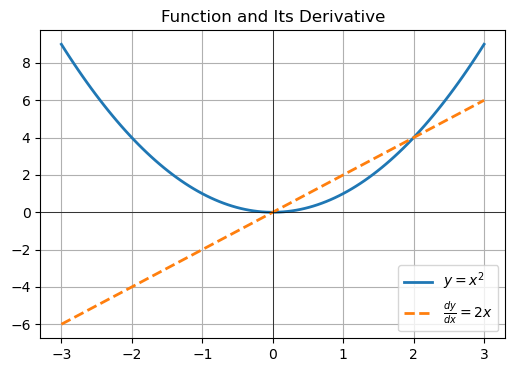

In [49]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define x values
x = tf.constant(np.linspace(-3, 3, 100), dtype=tf.float32)

# Compute y = x^2 and its derivative
with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**2
dy_dx = tape.gradient(y, x)

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(x, y, label='$y = x^2$', linewidth=2)
plt.plot(x, dy_dx, label="$\\frac{dy}{dx} = 2x$", linestyle='--', linewidth=2)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.title("Function and Its Derivative")
plt.show()


In [50]:
x.shape

TensorShape([100])

When calculating derivatives using `tf.GradientTape`, the use of `tf.reduce_sum` is crucial when your loss function is a tensor with more than one element (i.e., a vector or a matrix). Let's break down why and when you need it:

**Understanding the Jacobian and Gradient**

* **Jacobian:** If your output (the loss) is a vector or matrix, the derivative with respect to your input will be a Jacobian matrix. This matrix contains the partial derivatives of each output element with respect to each input element.
* **Gradient:** If your output (the loss) is a scalar, the derivative with respect to your input will be a gradient vector. This vector contains the partial derivatives of the scalar output with respect to each input element.

**Why `tf.reduce_sum` is Necessary**

`tf.GradientTape` is designed to compute the gradient of a *scalar* output with respect to the input variables. If your loss is a tensor (not a scalar), `tape.gradient` will return the Jacobian.

Here's the problem: for most optimization tasks, you want a single scalar value representing the overall loss, so you can then take the gradient of that scalar to update your model's parameters.

`tf.reduce_sum` helps you convert a tensor loss into a scalar loss by summing all its elements. This effectively aggregates the individual losses into a single value, allowing `tape.gradient` to compute the desired gradient vector.

**When to Use `tf.reduce_sum`**

1.  **Loss is a Tensor (Vector or Matrix):**
    * If your loss function produces a tensor (e.g., when calculating mean squared error across multiple data points without a prior reduction), you **must** use `tf.reduce_sum` (or another reduction operation like `tf.reduce_mean`) to obtain a scalar loss.
    * Example:
        ```python
        import tensorflow as tf

        x = tf.Variable(tf.constant([[1.0, 2.0], [3.0, 4.0]]))
        y = tf.constant([[2.0, 3.0], [4.0, 5.0]])

        with tf.GradientTape() as tape:
            loss = tf.square(x - y)  # loss is a tensor
            scalar_loss = tf.reduce_sum(loss)  # reduce to a scalar

        gradients = tape.gradient(scalar_loss, x)
        print(gradients)
        ```

2.  **Loss is Already a Scalar:**
    * If your loss function directly produces a scalar (e.g., some custom loss functions that already incorporate a reduction), you **do not** need to use `tf.reduce_sum`.
    * Example:
        ```python
        import tensorflow as tf

        x = tf.Variable(3.0)
        y = tf.constant(5.0)

        with tf.GradientTape() as tape:
            loss = tf.square(x - y) #loss is already a scalar

        gradients = tape.gradient(loss, x)
        print(gradients)
        ```

3.  **When you want the Jacobian:**
    * If you specifically need the Jacobian matrix (for advanced use cases like analyzing sensitivity or certain physics-based simulations), you can skip `tf.reduce_sum`. However, this is less common in standard neural network training.
    * Example:
        ```python
        import tensorflow as tf

        x = tf.Variable(tf.constant([[1.0, 2.0], [3.0, 4.0]]))
        y = tf.constant([[2.0, 3.0], [4.0, 5.0]])

        with tf.GradientTape() as tape:
            loss = tf.square(x - y) #loss is a tensor

        gradients = tape.jacobian(loss, x)
        print(gradients)
        ```

**In summary:**

* For typical neural network training with `tf.GradientTape`, use `tf.reduce_sum` (or `tf.reduce_mean`) to convert a tensor loss into a scalar loss before calculating gradients.
* If your loss is already a scalar, you don't need to reduce it.
* If you need the jacobian, then you do not reduce the tensor.

tf.reduce_sum is necessary when your loss is a tensor (not scalar) to convert it into a scalar so that tape.gradient() computes the gradient vector.

✅ No reduction is needed if the loss is already a scalar.

✅ If you need the Jacobian, avoid tf.reduce_sum since the Jacobian itself is a tensor (matrix) that maps the relationships between multiple outputs and inputs.

This distinction is crucial when designing custom loss functions or working with complex models.

WITH

 https://realpython.com/python-with-statement/

The with statement in Python is used to manage resources like files, network connections, or TensorFlow's GradientTape efficiently. It ensures proper setup and teardown, reducing the risk of resource leaks.

What is a Context Manager?
A context manager is a Python object that defines:

__enter__() → Code that runs when entering the context (e.g., opening a file).
__exit__() → Code that runs when exiting the context (e.g., closing the file).
Why Use with?
It simplifies resource management by automatically handling cleanup, even if an error occurs.

In [56]:
with open('data.txt', 'r') as file:
    content = file.read()  # File is automatically closed after this block

# No need to explicitly call file.close() — Python handles it.

In [57]:
content

'some data\n'

In [53]:
# custom context manager
class CustomContext:
    def __enter__(self):
        print("Entering the context")
        return self  # Optional, often useful for object references

    def __exit__(self, exc_type, exc_value, traceback):
        print("Exiting the context")
        if exc_type:
            print(f"Error: {exc_value}")
        return True  # Suppresses the exception (not always recommended)


In [54]:
with CustomContext() as ctx:
    print("Inside the context")
    raise ValueError("Something went wrong!")  # Exception is suppressed

print("Continuing program...")


Entering the context
Inside the context
Exiting the context
Error: Something went wrong!
Continuing program...


In [55]:
#Alternative: contextlib for Simpler Context Managers
#The contextlib module provides an easier way to create context managers:

from contextlib import contextmanager

@contextmanager
def custom_context():
    print("Entering the context")
    yield
    print("Exiting the context")

with custom_context():
    print("Inside the context")


Entering the context
Inside the context
Exiting the context


Key Use Cases
File I/O (open())
Database connections
Thread locks
TensorFlow’s GradientTape or PyTorch’s torch.no_grad()
Temporary resource management
In short, with ensures clean, efficient code by automatically managing resources.